In [57]:
import numpy as np
import pandas as pd
import tensorflow as tg
import random
from collections import deque
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

TypeError: 'str' object is not callable

In [2]:
SEQ_LEN = 60
FUTURE_PERIOD_PREDICT = 1
RATIO_TO_PREDICT = "mid"

In [3]:
def classify(current, future):
    if float(future)>float(current):
        return 1
    else:
        return 0
    
def preprocessing_df(df):
    pass

In [4]:
df = pd.read_csv("NSE.csv")
df.drop(columns={"Adj Close"}, inplace=True)
df['Date']= pd.to_datetime(df['Date']) 
df.sort_values(by='Date', inplace=True)

In [5]:
df.info() 


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2860 entries, 0 to 2859
Data columns (total 6 columns):
Date      2860 non-null datetime64[ns]
Open      2834 non-null float64
High      2834 non-null float64
Low       2834 non-null float64
Close     2834 non-null float64
Volume    2834 non-null float64
dtypes: datetime64[ns](1), float64(5)
memory usage: 156.4 KB


In [6]:
df.dropna(inplace=True)
df['mid'] = df['Low'] + (df['High']-df['Low'])/2
df['future'] = df[RATIO_TO_PREDICT].shift(-FUTURE_PERIOD_PREDICT)
df['target'] = list(map(classify, df[RATIO_TO_PREDICT], df['future']))

In [7]:
df.tail(3)

,Date,Open,High,Low,Close,Volume,mid,future,target
2857,2019-04-15,11667.000000,11704.599609,11648.250000,11690.349609,281300.0,11676.424805,11771.250000,1
2858,2019-04-16,11736.200195,11810.950195,11731.549805,11787.150391,343700.0,11771.250000,11797.325195,1
2859,2019-04-18,11856.150391,11856.150391,11738.500000,11752.799805,329500.0,11797.325195,NaN,0


In [8]:
df.drop(columns={"Date","Open","High","Low","Close","Volume","future"}, inplace=True)

In [9]:
times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(len(times)*0.1)]
last_20pct = sorted(df.index.values)[-int(len(times)*0.2)]
print('Last 10%: {} \nLast 20%: {}'.format(last_10pct, last_20pct))

Last 10%: 2576 
Last 20%: 2292


In [10]:
test_df = df[(df.index >= last_10pct)]
validation_df = df[(df.index >= last_20pct) & (df.index < last_10pct)]
train_df = df[(df.index < last_20pct)]

In [11]:
validation_df.head()

,mid,target
2292,8155.875000,1
2293,8172.899902,1
2294,8183.849854,1
2295,8199.699951,1
2296,8253.175293,1


In [12]:
test_data = test_df[RATIO_TO_PREDICT].as_matrix()
validation_data = validation_df[RATIO_TO_PREDICT].as_matrix()
train_data = train_df[RATIO_TO_PREDICT].as_matrix()

train_data = train_data.reshape(-1,1)
validation_data = validation_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

/home/abhishek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/home/abhishek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/abhishek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)

In [14]:
train_data = train_data.reshape(-1)
validation_data = scaler.transform(validation_data).reshape(-1)
test_data = scaler.transform(test_data).reshape(-1)

In [17]:
EMA = 0.0
beta = 0.1
for i in range(len(train_data)):
    EMA = beta*train_data[i] + (1-beta)*EMA
    train_data[i] = EMA

all_mid_data = np.concatenate([train_data,validation_data, test_data],axis=0)

In [18]:
X_train = []
y_train = []
for i in range(SEQ_LEN, len(train_data)):
    X_train.append(train_data[i-SEQ_LEN:i])
    y_train.append(train_data[i + (FUTURE_PERIOD_PREDICT-1)])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [45]:
X_valid = []
y_valid = []
for i in range(SEQ_LEN, len(validation_data)):
    X_valid.append(validation_data[i-SEQ_LEN:i])
    y_valid.append(validation_data[i + (FUTURE_PERIOD_PREDICT-1)])
X_valid, y_valid = np.array(X_valid), np.array(y_valid)

X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

In [46]:
X_test = []
y_test = []
for i in range(SEQ_LEN, len(test_data)):
    X_test.append(test_data[i-SEQ_LEN:i])
    y_test.append(test_data[i + (FUTURE_PERIOD_PREDICT-1)])
X_test, y_test = np.array(X_test), np.array(y_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [49]:
print('y train shape: {} \ny valid shape: {} \ny test shape: {}'.format(y_train.shape, y_valid.shape, y_test.shape))

y train shape: (2208,) 
y valid shape: (223,) 
y test shape: (223,)


In [51]:
X_train_2 = []
y_train_2 = []
for i in range(SEQ_LEN, len(train_data)):
    X_train_2.append(train_data[i-SEQ_LEN:i])
    y_train_2.append(train_data[i + (FUTURE_PERIOD_PREDICT-1)])
X_train_2, y_train_2 = np.array(X_train_2), np.array(y_train_2)

X_train_2 = np.reshape(X_train_2, (X_train_2.shape[0], X_train_2.shape[1], 1))

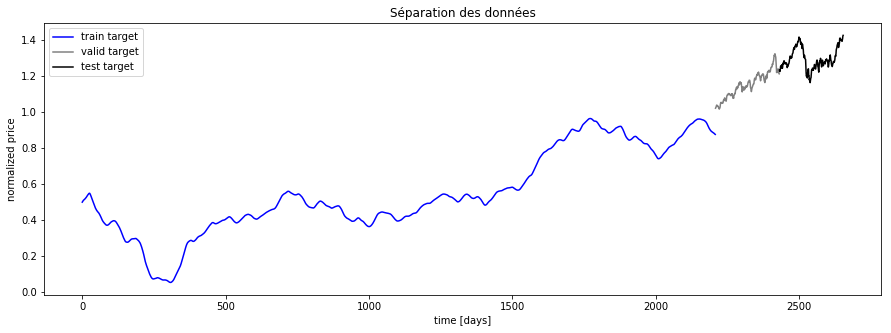

In [54]:
## show predictions
plt.figure(figsize=(15, 5))
plt.plot(np.arange(y_train_2.shape[0]), y_train_2, color='blue', label='train target')
plt.plot(np.arange(y_train_2.shape[0], y_train_2.shape[0]+y_valid.shape[0]), y_valid, color='gray', label='valid target')
plt.plot(np.arange(y_train_2.shape[0]+y_valid.shape[0], y_train_2.shape[0]+y_valid.shape[0]+y_test.shape[0]), y_test, color='black', label='test target')
plt.title('Séparation des données')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

# MODEL

In [61]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

import time
EPOCHS = 15
BATCH_SIZE = 32
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model